In [1]:
shared_cts = ['L6_IT_CTX_Glut',
 'CA1-ProS_Glut',
 'STR-PAL_Chst9_Gaba',
 'Pvalb_Gaba',
 'L23_IT_ENT_Glut',
 'OPC_NN',
 'L23_IT_CTX_Glut',
 'L5_ET_CTX_Glut',
 'L23_IT_PPP_Glut',
 'Lamp5_Gaba',
 'CA3_Glut',
 'Sst_Gaba',
 'LA-BLA-BMA-PA_Glut',
 'SUB-ProS_Glut',
 'Microglia_NN',
 'Astro-NT_NN',
 'Oligo_NN',
 'L6_CT_CTX_Glut',
 'L5_NP_CTX_Glut',
 'Vip_Gaba',
 'STR_D1_Sema5a_Gaba',
 'Astro-TE_NN',
 'DG_Glut',
 'VLMC_NN',
 'L6bCT_ENT_Glut',
 ] #'STR_D1_Gaba'

In [2]:
def get_luisa_deg(ct):
    deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
    expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
    use_genes = expr[expr.sum(axis = 1) > 0.1].index
    stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)
    
    luisa_deg = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
    luisa_deg['log2(18mo/2mo)'] = np.log2(luisa_deg['fc']) 
    luisa_deg['-log10(padj)'] = -np.log10(luisa_deg['fdr'] + _min)
    luisa_deg =luisa_deg[luisa_deg['fdr'] < 0.5]
    return luisa_deg

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pvalue_cutoff = 0.01
fc_cutoff = 0.1
_min = 1e-200
res = 25000

In [5]:
all_diff_domain = pd.read_csv('ALL.Diff.Domain.csv', index_col = 0)
all_diff_domain = all_diff_domain[all_diff_domain['celltype'].isin(shared_cts)]

In [6]:
example_cts = all_diff_domain['celltype'].value_counts().index[:6]
#example_cts = ['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut', 'L6_CT_CTX_Glut']
example_cts

Index(['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut', 'Astro-TE_NN',
       'CA3_Glut', 'L6_CT_CTX_Glut'],
      dtype='object', name='celltype')

In [7]:
#example_cts = ['DG_Glut', 'CA1-ProS_Glut', 'CA3_Glut','Astro-TE_NN', 'L23_IT_CTX_Glut', 'LA-BLA-BMA-PA_Glut'] #'L6bCT_ENT_Glut',

In [8]:
luisa_dir = '/data/female-amb/Diff.Result/luisa_deg'
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]

In [14]:
deg_number = {}
for ct in example_cts:
    all_overlap = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col ='gene_name')
    all_overlap= all_overlap[all_overlap['18mo-8wk'] > 0]

    all_deg = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
    all_deg['-log10(padj)'] = -np.log10(all_deg['p_val_adj']+ _min)
    all_deg['log2(18mo/2mo)'] = -all_deg['avg_log2FC']
    all_deg = all_deg[(abs(all_deg['log2(18mo/2mo)']) > fc_cutoff) & (all_deg['p_val_adj'] <  pvalue_cutoff)]
    all_down_genes, all_up_genes = all_deg[all_deg['log2(18mo/2mo)'] < 0].shape[0], all_deg[all_deg['log2(18mo/2mo)']> 0].shape[0]
    
    shared_deg_df = all_deg[all_deg.index.isin(all_overlap.index)]
    down_genes, up_genes = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] < 0].shape[0], shared_deg_df[shared_deg_df['log2(18mo/2mo)']> 0].shape[0]
    deg_number[ct] = (all_down_genes, all_up_genes, down_genes, up_genes)

deg_number = pd.DataFrame(deg_number, index = ['all_down_genes','all_up_genes','domain_down_genes','domain_up_genes']).T
deg_number['cell_type'] = deg_number.index

deg_number['all_ratio(down/all)'] = round(deg_number['all_down_genes']/(deg_number['all_down_genes']+ deg_number['all_up_genes']),2)
deg_number['domain_ratio(down/all)'] = round(deg_number['domain_down_genes']/(deg_number['domain_up_genes'] + deg_number['domain_down_genes']),2)
deg_number

,all_down_genes,all_up_genes,domain_down_genes,domain_up_genes,cell_type,all_ratio(down/all),domain_ratio(down/all)
DG_Glut,4676,724,674,93,DG_Glut,0.87,0.88
CA1-ProS_Glut,784,1259,51,84,CA1-ProS_Glut,0.38,0.38
L23_IT_CTX_Glut,1968,510,51,21,L23_IT_CTX_Glut,0.79,0.71
Astro-TE_NN,163,157,10,8,Astro-TE_NN,0.51,0.56
CA3_Glut,327,1059,5,19,CA3_Glut,0.24,0.21
L6_CT_CTX_Glut,2012,364,48,23,L6_CT_CTX_Glut,0.85,0.68


In [10]:
deg_number['domain_down_genes'] *= -1
deg_number['all_down_genes'] *= -1

Text(0.5, 1.0, 'all DEGs')

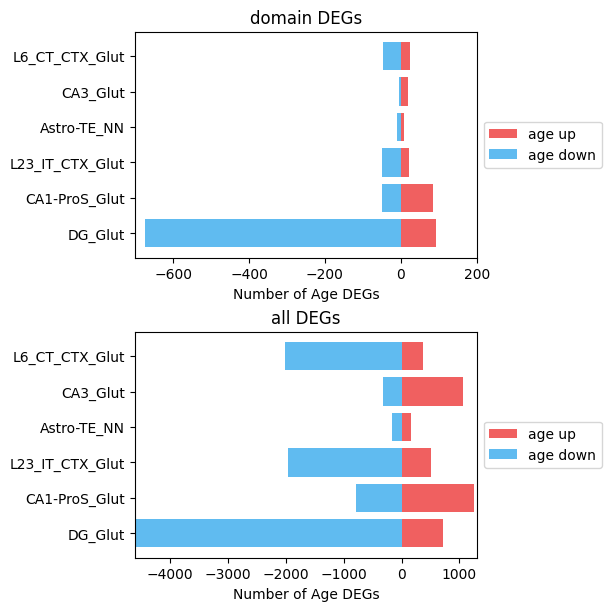

In [11]:
# Plotting
fig, axes = plt.subplots(figsize = (6,6), nrows = 2, dpi = 100, constrained_layout = True)

ax = axes[0]
ax.barh(deg_number['cell_type'], deg_number['domain_up_genes'],  color='#f06060',label='age up')
ax.barh(deg_number['cell_type'], deg_number['domain_down_genes'], color='#60bbf0', label='age down')
ax.set_xlabel('Number of Age DEGs')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(-700, 200)
ax.set_title('domain DEGs')

ax = axes[1]
ax.barh(deg_number['cell_type'], deg_number['all_up_genes'],  color='#f06060',label='age up')
ax.barh(deg_number['cell_type'], deg_number['all_down_genes'], color='#60bbf0', label='age down')
ax.set_xlabel('Number of Age DEGs')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(-4600, 1300)
ax.set_title('all DEGs')
#fig.savefig(f"cross_boundary.domain_genes.up_or_down.pdf", bbox_inches = 'tight')

In [12]:
# ncols = 2
# nrows = 2
# cross_boundary = True
# fig, axes = plt.subplots(figsize = (ncols*2,nrows*2), 
#                          ncols = ncols, nrows = nrows, 
#                          dpi = 200, constrained_layout = True)
# for ct, ax in zip(example_cts,axes.ravel()):
#     all_deg = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
#     all_deg['-log10(padj)'] = -np.log10(all_deg['p_val_adj']+ _min)
#     all_deg['log2(18mo/2mo)'] = -all_deg['avg_log2FC']
#     all_deg = all_deg[(abs(all_deg['log2(18mo/2mo)']) > fc_cutoff) & (all_deg['p_val_adj'] <  pvalue_cutoff)]
    
#     all_overlap = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col ='gene_name')
#     all_overlap= all_overlap[all_overlap['18mo-8wk'] > 0]
    
#     all_overlap['start'] = all_overlap['start'] - res
#     all_overlap['end'] = all_overlap['end'] - res

    
#     if cross_boundary == True:
#         cross_boundary_genes_1 = all_overlap[(all_overlap['gene_start'] < all_overlap['start']) & (all_overlap['gene_end'] > all_overlap['start'])]
#         cross_boundary_genes_2 = all_overlap[(all_overlap['gene_end'] > all_overlap['end']) & (all_overlap['gene_start'] < all_overlap['end'])]
#         all_overlap = pd.concat([cross_boundary_genes_1, cross_boundary_genes_2])
#     elif cross_boundary == False:
#         cross_boundary_genes_1 = all_overlap[(all_overlap['gene_start'] < all_overlap['start']) & (all_overlap['gene_end'] > all_overlap['start'])]
#         cross_boundary_genes_2 = all_overlap[(all_overlap['gene_end'] > all_overlap['end']) & (all_overlap['gene_start'] < all_overlap['end'])]
#         tmp = pd.concat([cross_boundary_genes_1, cross_boundary_genes_2])
#         all_overlap = all_overlap[~all_overlap.index.isin(tmp.index)]
    
#     shared_deg_df = all_deg[all_deg.index.isin(all_overlap.index)]    
#     sns.scatterplot(data = all_deg,
#                     linewidth = 0,
#                     ax = ax,
#                     color = 'lightgrey',
#                     s = 3,
#                     x = 'log2(18mo/2mo)',
#                     y = '-log10(padj)')

#     sns.scatterplot(data = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] < 0],
#                     linewidth = 0,
#                     ax = ax,
#                     color = 'blue',
#                     s = 6,
#                     x = 'log2(18mo/2mo)',
#                     y = '-log10(padj)')

#     sns.scatterplot(data = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] > 0],
#                     linewidth = 0,
#                     ax = ax,
#                     color = 'red',
#                     s = 6,
#                     x = 'log2(18mo/2mo)',
#                     y = '-log10(padj)')
#     ax.set_title(ct)
#     ylim = shared_deg_df['-log10(padj)'].max() + 5
#     if ylim > 200:
#         ylim = 150
#     ax.set(xlim = (-3,3), ylim = (0,ylim) ) #
    
#     top_genes = shared_deg_df[(shared_deg_df['log2(18mo/2mo)'] < -0.8)]
#     top_genes = top_genes.sort_values('-log10(padj)',ascending = False).head(5)
#     for _, row in top_genes.iterrows():
#         ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
#                     textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)